# Data Integration, Graph Construction and Analysis

In [44]:
import pandas as pd
import numpy as np
import re

### Create doc to vector

In this notebook, we merge the IMDb information with MovieLens records.
In addition, we create a feature vector that encodes the information in a format that allows computing distances.
We use the features to compute a similarity matrix using cosine similarity.
We extract a graph from the matrix and get an analysis of the graph.

In [2]:
columns_movies = ["movie_id", "title", "imdb_idx",
                  "movie_kind", "release", "imdb_id", "phonetic", "episode_id",
                  "season", "episode", "series_years", "md5"]

df_IMDb_movies = pd.read_csv('data/title.csv', delimiter=',', names=columns_movies, encoding = "ISO-8859-1", low_memory=False) 
df_IMDb_movies = df_IMDb_movies.drop(columns=["imdb_idx", "imdb_id", "phonetic", "md5", "episode_id", "episode", "movie_kind", "season", "series_years"])
df_IMDb_movies = df_IMDb_movies.dropna(subset=['release'])
df_IMDb_movies["release"] = df_IMDb_movies["release"].apply(lambda x : str(int(x)).split("-")[-1])
# we lowered in MovieLens as well
df_IMDb_movies = df_IMDb_movies.dropna(subset=["title"])
df_IMDb_movies["title"] = df_IMDb_movies["title"].apply(lambda x: x.lower())

# drop rows where movie starts with brackets, those are some strange names...
df_IMDb_movies = df_IMDb_movies[~df_IMDb_movies.title.str.startswith("(")]

# handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_IMDb_movies[df_IMDb_movies.title.str.contains("(", regex=False)]
_df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_IMDb_movies = df_IMDb_movies.append(_df)

print(df_IMDb_movies.dtypes)
print(df_IMDb_movies.shape)
df_IMDb_movies.head()

/Users/dias/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


movie_id     int64
title       object
release     object
dtype: object
(1776458, 3)


,movie_id,title,release
1,5156,josie duggar's 1st shoes,2010
5,40704,anniversary,1971
7,149337,mellody hobson,2005
8,32020,kiss me kate,2011
10,112085,the best of olivia,2008


In [3]:
def clean_movie_title(movie_title):
    if movie_title.split(" ")[-1].startswith("("):
        # remove year from the title, e.g. Toy Story (1995) --> Toy Story
        movie_title = (" ".join(movie_title.split(" ")[:-1])).strip()

    if movie_title.title().split(',')[-1].strip() in ['The', 'A']:
        # article + movie title, e.g. Saint, The --> The Saint
        movie_title = (movie_title.title().split(',')[-1].strip() + " " + " ".join(movie_title.title().split(',')[:-1])).strip()

    # otherwise, it was converting The Devil's Advocate to The Devil'S Advocate
    movie_title = movie_title.lower()
    return movie_title

In [4]:
column_item = ["movie_id_ml", "title", "release", "vrelease", "url", "unknown", 
                    "action", "adventure", "animation", "childrens", "comedy",
                   "crime", "documentary", "drama", "fantasy", "noir", "horror",
                   "musical", "mystery", "romance", "scifi", "thriller",
                   "war", "western"]

df_ML_movies = pd.read_csv('data/u.item', delimiter='|', names=column_item, encoding = "ISO-8859-1") 
df_ML_movies = df_ML_movies.drop(columns=["vrelease"])
df_ML_movies["title"] = df_ML_movies["title"].apply(lambda row : clean_movie_title(row))   
df_ML_movies["release"] = df_ML_movies["release"].apply(lambda x : str(x).split("-")[-1])

# drop rows where movie starts with brackets, those are some strange names...
df_ML_movies = df_ML_movies[~df_ML_movies.title.str.startswith("(")]

# handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_ML_movies[df_ML_movies.title.str.contains("(", regex=False)]
_df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_ML_movies = df_ML_movies.append(_df)

print(df_ML_movies.shape)
print(df_ML_movies.dtypes)
df_ML_movies.head()

(1767, 23)
movie_id_ml     int64
title          object
release        object
url            object
unknown         int64
action          int64
adventure       int64
animation       int64
childrens       int64
comedy          int64
crime           int64
documentary     int64
drama           int64
fantasy         int64
noir            int64
horror          int64
musical         int64
mystery         int64
romance         int64
scifi           int64
thriller        int64
war             int64
western         int64
dtype: object


/Users/dias/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,movie_id_ml,title,release,url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
df = pd.merge(df_ML_movies, df_IMDb_movies, on=["title", "release"])
movie_ids = list(df.movie_id_ml.unique())

In [6]:
movie_dim = max(list(df_ML_movies.movie_id_ml.unique()))
movie_dim

1682

We have successfully merged the MovieLens movie records with the respective IMDb titles. As a result, we have associated the primary keys of the two databases. The association allows us to propagate title-specific information from the IMDb to the MovieLens dataset.

The goal is to enhance movie records with additional features in order to build a graph that captures the similarity of movies more accurately. Movies can be linked to a set of keywords and participating cast members. We use a vector representation of the features, because it is popular in Machine Learning and allows direct computation for a number of distance metrics. 1s represent occurences of a term, whereas 0s represent the absence of a term. In the subsequent sections, we add the additional features in a NumPy matrix.

###  Keyword to vector transformation

First, we build a vector representation for the keywords that correspond to each movie. We load the M:N relation and perform the join.

In [7]:
#load M:N relation relation. We do not care about the keyword text representation
column_movie_keyword = ["mkid", "movie_id", "keyword_id"]

df_movie_keyword = pd.read_csv('data/movie_keyword.csv', delimiter=',', names=column_movie_keyword, encoding = "ISO-8859-1") 
print(df_movie_keyword.dtypes)
print(df_movie_keyword.shape)
df_movie_keyword = df_movie_keyword.drop(columns=["mkid"])
df_movie_keyword.head()

mkid          int64
movie_id      int64
keyword_id    int64
dtype: object
(4523930, 3)


,movie_id,keyword_id
0,2,1
1,11,2
2,22,2
3,44,3
4,24,2


In [8]:
#join movielens movies with the M:N relation
#each resulting row (m,k) shows that movie m is related to keyword k
df_movies_keywords = pd.merge(df, df_movie_keyword, on="movie_id")
df_movies_keywords = df_movies_keywords[["movie_id_ml","keyword_id"]]
df_movies_keywords.head()

,movie_id_ml,keyword_id
0,1,834
1,1,2956
2,1,66752
3,1,93318
4,1,73783


In [9]:
#convert to numpy and prepare for iteration and creation of vectors
np_movies_keywords = df_movies_keywords.to_numpy()
np_movies_keywords

array([[    1,   834],
       [    1,  2956],
       [    1, 66752],
       ...,
       [ 1575,  2242],
       [ 1575, 11548],
       [ 1635,     1]])

In [11]:
#initialize vector representation
num_keyword = 134170
keyword_vector = np.zeros((movie_dim, num_keyword))

#if row (m,k) exists, then set cell a_{m,k}
for i in range(np_movies_keywords.shape[0]) :
    #-1 is used because indexing starts from 0
    row = np_movies_keywords[i,0]-1
    column = np_movies_keywords[i,1]-1
    keyword_vector[row, column] = 1
        

We now have a vector representation. As an extra step, we drop columns that are not useful for computing movie similarities (for example, keywords with no matching MovieLens movie.

In [12]:
#drop columns with at most one 1, because they are useless
#this way further processing will be cheaper
#keep indexes of useful columns and drop the rest
useful_keywords = []

for i in range(keyword_vector.shape[1]) :
    cnt = keyword_vector[:,i].sum()
    if cnt > 1 :
        useful_keywords += [i]
        
print(len(useful_keywords))
keyword_vector = keyword_vector[:,useful_keywords]
print(keyword_vector.shape)
print(keyword_vector.sum())

10243
(1682, 10243)
89924.0


### Create cast vector

Similarly, we build the cast vector. We load an M:N relation between cast members and movies.

In [13]:
#load M:N relation for cast. person_id corresponds to cast member, movie_id is the imdb movie primary key
column_cast = ["cast_id", "person_id", "movie_id", "person_role_id", "note", "nr_order", "role_id"]

df_cast = pd.read_csv('data/cast_info.csv', delimiter=',', names=column_cast, encoding = "ISO-8859-1", low_memory=False) 
df_cast['role_id'] = pd.to_numeric(df_cast['role_id'], errors='coerce')
df_cast = df_cast.drop(columns=["note", "nr_order", "person_role_id"])

print(df_cast.dtypes)
print(df_cast.shape)
df_cast.head()

cast_id        int64
person_id      int64
movie_id       int64
role_id      float64
dtype: object
(36243322, 4)


,cast_id,person_id,movie_id,role_id
0,1,1,968504,1.0
1,2,2,2163857,1.0
2,3,2,2324528,1.0
3,4,3,1851347,1.0
4,5,4,1681365,1.0


In [14]:
#perform the join, similar to keyword tuples
df_cast_ml = pd.merge(df, df_cast, on="movie_id")
df_cast_ml = df_cast_ml[["movie_id_ml","person_id"]]
df_cast_ml.head()

,movie_id_ml,person_id
0,1,30260
1,1,46332
2,1,46332
3,1,66226
4,1,128339


In [15]:
np_cast = df_cast_ml.to_numpy()

In [18]:
#start with a 0 vector representation and fill using the join table
num_people = 4167491
cast_vector = np.zeros((movie_dim, num_people))

#set cells a_{i,j} if (i,j) in join table
for i in range(np_cast.shape[0]) :
    #account for indexing starting from 0
    row = np_cast[i,0]-1
    column = np_cast[i,1]-1
    cast_vector[row, column] = 1
        

Next we drop columns that are not useful for similarity computations

In [27]:
#drop columns with at most one 1, because they are useless
#this way further processing will be cheaper
#keep indexes of useful columns and drop the rest
useful_cast = []

for i in range(cast_vector.shape[1]) :
    cnt = cast_vector[:,i].sum()
    if cnt > 1 :
        useful_cast += [i]
        
print(len(useful_cast))
cast_vector = cast_vector[:,useful_cast]
print(cast_vector.shape)
print(cast_vector.sum())

19932
(1682, 19932)
64946.0


Now we concatenate the two vector representations to have the combined feature set.

In [29]:
movie_vec = np.concatenate((keyword_vector, cast_vector), axis=1)
movie_vec.shape

(1682, 30175)

Finally, we append the vector representation of the genres that originally exists in MovieLens

In [30]:
genres = ["movie_id_ml", "unknown", "action", "adventure", "animation", "childrens", "comedy",
                   "crime", "documentary", "drama", "fantasy", "noir", "horror",
                   "musical", "mystery", "romance", "scifi", "thriller",
                   "war", "western"]

df_genres = df_ML_movies[genres]

In [31]:
np_genres = df_genres.to_numpy()

In [32]:
np_genres.shape

(1767, 20)

In [33]:
genre_vector = np.zeros((movie_dim, 19))

for i in range(np_genres.shape[0]) :
    row = np_genres[i,0]-1
    genre_vector[row,:] += np_genres[i,1:]
    
genre_vector = (genre_vector > 0).astype(int)

In [34]:
genre_vector.shape

(1682, 19)

In [35]:
movie_vec = np.concatenate((movie_vec, genre_vector), axis=1)
movie_vec.shape

(1682, 30194)

### Computing cosine similarity

The data has a very high dimensionality. Euclidian distance is unlikely to work under these circumstances. Instead, we opt for cosine similarity.

In [40]:
#normalize the vector per row
#then, cosine similarity is the dot product of two rows
movie_vec_norm = np.zeros(movie_vec.shape)

for i in range(movie_vec_norm.shape[0]) :
    local_norm = np.linalg.norm(movie_vec[i,:])
    if local_norm > 0:
        movie_vec_norm[i,:] = movie_vec[i,:]/local_norm

In [41]:
#compute the similarity matrix
movie_dist_cosine = np.zeros((movie_vec.shape[0], movie_vec.shape[0]))

for i in range(movie_vec_norm.shape[0]) :
    for j in range(movie_vec_norm.shape[0]) :
        #avoid duplicate computations
        if i < j :
            #cosine is the dot product
            dist = movie_vec_norm[i,:].dot(movie_vec_norm[j,:])
            movie_dist_cosine[i,j] = dist
            movie_dist_cosine[j,i] = dist

We test how many values are non-zero in the similarity matrix.

In [42]:
#float comparisons are tricky so chose some very small value
epsilon = 0.001
1 - (movie_dist_cosine < epsilon).astype(int).sum()/(movie_dist_cosine_filtered.shape[0] ** 2)

0.6129720719204955

We plot the similarity values as a histogram

In [45]:
from matplotlib import pyplot as plt

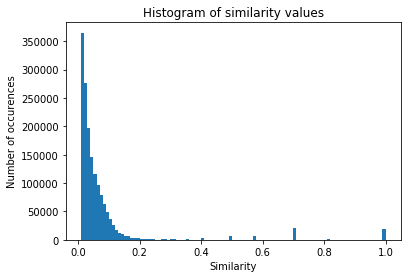

In [46]:
#don't use plt.hist because of performance
y,x = np.histogram(movie_dist_cosine, bins=100)

plt.bar(x[1:-1], y[1:], width = 0.01, align='edge')
plt.title('Histogram of similarity values')
plt.xlabel('Similarity')
plt.ylabel('Number of occurences')
plt.show()

We prune edges with low similarities. Originally, we considered pruning at 0.2, however the resulting graph was very sparse. Thus, we chose 0.1.

In [47]:
#get the threshold filter and create the graph movie_dist_cosine_filtered
threshold = 0.1
pruning_filter = (movie_dist_cosine > threshold).astype(int)
movie_dist_cosine_filtered = pruning_filter * movie_dist_cosine

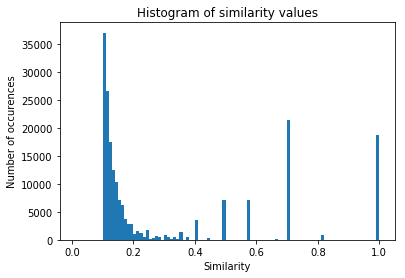

In [48]:
y,x = np.histogram(movie_dist_cosine_filtered, bins=100)

plt.bar(x[1:-1], y[1:], width = 0.01, align='edge')
plt.title('Histogram of similarity values')
plt.xlabel('Similarity')
plt.ylabel('Number of occurences')
plt.show()

We measure the density of the graph again. Now, it is close to 7%.

In [122]:
epsilon = 0.001
(movie_dist_cosine_filtered < epsilon).astype(int).sum()
1 - (movie_dist_cosine_filtered < epsilon).astype(int).sum()/(movie_dist_cosine_filtered.shape[0] ** 2)

0.06989301281951588

To get extra statistics on the graph, we compute the histogram of degrees.

22


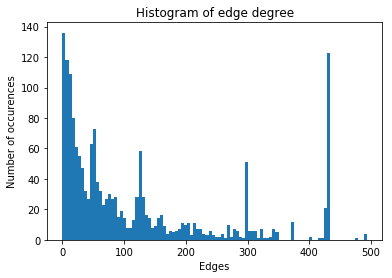

In [50]:
#get adjacency matrix
adjacency = (movie_dist_cosine_filtered > epsilon).astype(int)

#sum edges to get degree
degrees = np.sum(adjacency, axis=1)
#print number of nodes with 0 degree
print((degrees == 0).astype(int).sum())

#plot histogram
plt.hist(degrees, bins = 100)
plt.title('Histogram of edge degree')
plt.xlabel('Edges')
plt.ylabel('Number of occurences')
plt.show()

#22 unconnected with 0.1, 815 with 0.2

We also plot the graph for different similarity thresholds.

In [51]:
threshold1 = 0.01
threshold2 = 0.05
threshold3 = 0.1
threshold4 = 0.2

movie_graph1 = (movie_dist_cosine > threshold1).astype(int)
movie_graph2 = (movie_dist_cosine > threshold2).astype(int)
movie_graph3 = (movie_dist_cosine > threshold3).astype(int)
movie_graph4 = (movie_dist_cosine > threshold4).astype(int)

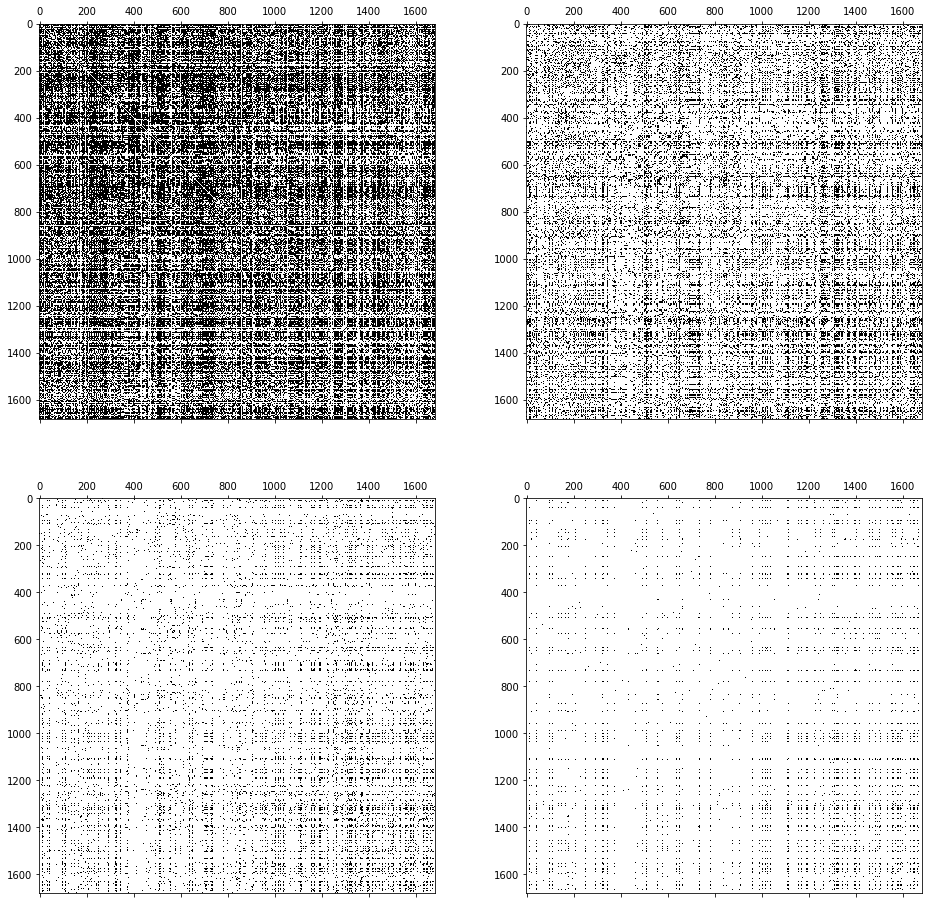

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].spy(movie_graph1);
axes[0, 1].spy(movie_graph2);
axes[1, 0].spy(movie_graph3);
axes[1, 1].spy(movie_graph4);

### Spectral analysis

Another type information we can get is the spectral description of the graph. We use the utilities from the homeworks to perform the eigen-decomposition.

In [53]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # Your code here
    n = adjacency.shape[0]
    
    # D is degree matrix (in our case the degree is represented with the weight of edge)
    D = np.diag(np.sum(adjacency, axis=1))
    L = D - adjacency
    
    if not normalize:
        return L

    # L_norm = D^(-1/2) @ L @ D^(-1/2)
    D_norm = np.diag(np.sum(adjacency, axis=1)**(-0.5))
    L_norm = D_norm @ L @ D_norm
    
    return L_norm

In [54]:
adjacency = movie_dist_cosine_filtered

In [55]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)

In [56]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)
    
    #order the eigenvalues
    sortInd = np.argsort(lamb)
    
    return lamb[sortInd], U[:, sortInd]

In [57]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)

Text(0.5,1,'Eigenvalues $L_{comb}$')

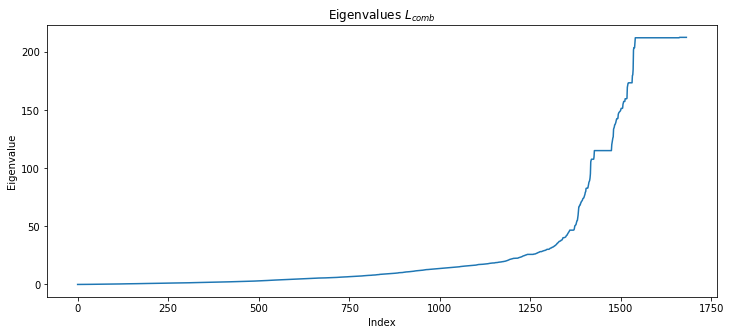

In [58]:
plt.figure(figsize=(12,5))
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')

### Spectral Clustering

We also run spectral clustering on the nodes of the graph.

In [60]:
from sklearn.cluster import KMeans

In [61]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        # Your code here
        self.clustering_method =  KMeans(n_clusters=n_classes, random_state=0)
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        # Your code here
        self.laplacian = compute_laplacian(adjacency, self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        self.U = self.U[:,:self.n_classes]
        
        #if self.normalize:
        self.U /= np.sqrt(np.sum(self.U**2,axis=1))[:, np.newaxis]
       
        y_pred = self.clustering_method.fit_predict(self.U)
        
        
        return y_pred

In [62]:
spectral_clustering = SpectralClustering(n_classes=250, normalize=False)
y_pred = spectral_clustering.fit_predict(adjacency)

In [63]:
clusters = {}
np_ml_movies = df_ML_movies.to_numpy()

for i in range(250) : 
    clusters[i] = []

for i in range(y_pred.shape[0]):
    idx = y_pred[i]
    clusters[idx] += [np_ml_movies[i,1]]

In [64]:
clusters

{0: ['get shorty',
  'richard iii',
  'postino, il',
  "mr. holland's opus",
  'french twist (gazon maudit)',
  'the white balloon',
  "antonia's line",
  'braveheart',
  'taxi driver',
  'the brothers mcmullen',
  'mad love',
  'nadja',
  'to wong foo, thanks for everything! julie newmar',
  'clerks',
  'dolores claiborne',
  'eat drink man woman',
  'legends of the fall',
  'the madness of king george',
  'the professional',
  'three colors: red',
  'three colors: blue',
  'three colors: white',
  'four weddings and a funeral',
  'faster pussycat! kill! kill!',
  'free willy',
  'searching for bobby fischer',
  'welcome to the dollhouse',
  'fargo',
  'theodore rex',
  'moll flanders',
  'kids in the hall: brain candy',
  'mystery science theater 3000: the movie',
  'operation dumbo drop',
  'the truth about cats & dogs',
  'horseman on the roof, the (hussard sur le toit, le)',
  'cold comfort farm',
  'the frighteners',
  'phenomenon',
  'big night',
  'd3: the mighty ducks',
  'the

### k Nearest-Neighbors

To get an idea on how accurate the graph is, we compute the 10 nearest neighbors for each node:

In [65]:
k = 10

In [66]:
np_ml_movies = df_ML_movies.to_numpy()
np_ml_movies

array([[1, 'toy story', '1995', ..., 0, 0, 0],
       [2, 'goldeneye', '1995', ..., 1, 0, 0],
       [3, 'four rooms', '1995', ..., 1, 0, 0],
       ...,
       [1639, 'azucar amargo', '1996', ..., 0, 0, 0],
       [1652, 'feng yue', '1997', ..., 0, 0, 0],
       [1682, 'schrei aus stein', '1996', ..., 0, 0, 0]], dtype=object)

In [67]:
for i in range(adjacency.shape[0]):
    #get knn
    idx = adjacency[i,:].argsort()[-k:]
    #exclude non-connected choices
    idx = [j for j in idx if adjacency[i,j] > 0]
    #collect movie names and similarity
    neighbors = [(np_ml_movies[j,1], adjacency[i,j]) for j in idx]
    print(i,np_ml_movies[i,1],neighbors)

0 toy story [('the wrong trousers', 0.11585688927269845), ('mighty morphin power rangers: the movie', 0.11631212438304561), ('hercules', 0.1175352512808681), ('the hunchback of notre dame', 0.12047528242927065), ('jingle all the way', 0.12145102025434007), ('first kid', 0.12477059832810866), ('beauty and the beast', 0.12648537023883405), ('the next karate kid', 0.1269148633940705), ('the lion king', 0.13525532533308657), ('home alone', 0.14160406371033446)]
1 goldeneye [('die hard 2', 0.1485070185356051), ('the jackal', 0.15126731029267332), ('double team', 0.15326425834455354), ('the fifth element', 0.15695225072935082), ('batman forever', 0.158970161079422), ('desperado', 0.16598500055174645), ('die hard', 0.17169807684373387), ('broken arrow', 0.1719615458857992), ('true lies', 0.17642698833636178), ('tomorrow never dies', 0.3405453090913766)]
2 four rooms [('reservoir dogs', 0.1056986713719224), ('my crazy life (mi vida loca)', 0.10886919764059902), ('pulp fiction', 0.1231017255757

670 bride of frankenstein [('tales from the crypt presents: bordello of blood', 0.11396057645963795), ('tales from the crypt presents: demon knight', 0.11396057645963795), ('cronos', 0.11396057645963795), ("stephen king's the langoliers", 0.11396057645963795), ("blood for dracula (andy warhol's dracula)", 0.11396057645963795), ('spirits of the dead (tre passi nel delirio)', 0.11396057645963795), ('american werewolf in london, an', 0.11396057645963795), ('the amityville curse', 0.11396057645963795), ('the body snatcher', 0.1216517748906199), ('young frankenstein', 0.17361895250765816)]
671 candyman [('akira', 0.10008009612817945), ('the omen', 0.10390486669322624), ('lord of illusions', 0.10760355775263959), ('freeway', 0.11126972805283734), ('scream', 0.12183925606506522), ('a nightmare on elm street', 0.12633023402295096), ('kalifornia', 0.1274511322542921), ('candyman: farewell to the flesh', 0.20483662259967567)]
672 cape fear [('thinner', 0.1125596875347411), ('germinal', 0.1127836

1110 double happiness [('8 1/2', 1.0), ('tie me up! tie me down!', 1.0), ('flirt', 1.0), ('double vie de véronique, la (double life of veronique, the)', 1.0), ('the journey of august king', 1.0), ('blood & wine', 1.0), ('dangerous ground', 1.0), ('nelly & monsieur arnaud', 1.0), ('the wedding gift', 1.0), ('scream of stone (schrei aus stein)', 1.0)]
1111 cobb [('boys in venice', 0.11704114719613057), ('forbidden christ, the (cristo proibito, il)', 0.11704114719613057), ('hollow reed', 0.11704114719613057), ('bonheur, le', 0.11704114719613057), ('gabbeh', 0.11704114719613057), ('mondo', 0.11704114719613057), ('for ever mozart', 0.11704114719613057), ('ballad of narayama, the (narayama bushiko)', 0.11704114719613057), ('scream of stone (schrei aus stein)', 0.11704114719613057), ('tin cup', 0.22850810680389594)]
1112 mrs. parker and the vicious circle [('delta of venus', 0.10259783520851541), ('nil by mouth', 0.10259783520851541), ('kaspar hauser', 0.10259783520851541), ('hate (haine, la)

1619 the sixth man [('theodore rex', 0.105999788000636), ('schizopolis', 0.105999788000636), ('quartier mozart', 0.105999788000636), ('maybe, maybe not (bewegte mann, der)', 0.105999788000636), ('rocket man', 0.105999788000636), ('clerks', 0.105999788000636), ('waiting for guffman', 0.105999788000636), ('celtic pride', 0.10769589230459235), ('hoop dreams', 0.1188148524939073), ('blue chips', 0.12656847745800884)]
1620 butterfly kiss [('crash', 0.7071067811865475), ('the spanish prisoner', 0.7071067811865475), ('loch ness', 0.7071067811865475), ('supercop', 0.7071067811865475), ('head above water', 0.7071067811865475), ('red rock west', 1.0), ('underworld', 1.0), ('nikita (la femme nikita)', 1.0), ('killing zoe', 1.0), ('killer (bulletproof heart)', 1.0)]
1621 paris, france [('window to paris', 0.18257418583505536), ('mostro, il', 0.18257418583505536), ("monty python's life of brian", 0.18257418583505536), ('bewegte mann, der', 0.18257418583505536), ('celestial clockwork', 0.18257418583

### Dimensionality Reduction

Finally, we use Laplacian eigenmaps to perform dimensionality reduction.

In [72]:
#get corresponding embedding from eigenvectors
dims = 150

reduced = U_comb[:,:dims]
reduced.shape

(1682, 150)

In [73]:
#compute new distance matrix for embedded space
movie_dist_reduced = np.zeros((movie_vec.shape[0], movie_vec.shape[0]))

for i in range(movie_vec_norm.shape[0]) :
    for j in range(movie_vec_norm.shape[0]) :
        if i < j :
            dist = np.linalg.norm(reduced[i,:]-reduced[j,:])
            movie_dist_reduced[i,j] = dist
            movie_dist_reduced[j,i] = dist

In [74]:
#compute new nearest neighbors for nodes
for i in range(movie_dist_reduced.shape[0]):
    idx = movie_dist_reduced[i,:].argsort()[:k]
    idx = [j for j in idx if i != j]
    neighbors = [(np_ml_movies[j,1], movie_dist_reduced[i,j]) for j in idx]
    print(i,np_ml_movies[i,1],neighbors)

0 toy story [('snow white and the seven dwarfs', 0.026792911555489657), ('cinderella', 0.029362466703853708), ('pinocchio', 0.033394293679010895), ('fantasia', 0.03597270747116991), ('the aristocats', 0.038638882771857536), ('the fox and the hound', 0.03869516299492463), ('dumbo', 0.03959861246369132), ('alice in wonderland', 0.039702765867588925), ('anastasia', 0.04657517274159729)]
1 goldeneye [('tomorrow never dies', 0.010640564513512227), ('under siege', 0.012573109750684765), ('clear and present danger', 0.012576781021453652), ('the rock', 0.01258616151433939), ('drop zone', 0.012651628283638075), ('double team', 0.012682334935043109), ('last action hero', 0.012763981005513354), ('die hard: with a vengeance', 0.012787654070428731), ('street fighter', 0.012841226670949427)]
2 four rooms [('beverly hills ninja', 0.038660323928684265), ('apocalypse now', 0.07035591962189575), ('the prophecy', 0.07463651998520587), ('twelve monkeys', 0.09986957189114633), ('conspiracy theory', 0.10111

622 angels in the outfield [('carpool', 0.006444421634056044), ('herbie rides again', 0.006612606914851073), ('the big green', 0.006660463591190374), ('kazaam', 0.006715133427725721), ('that darn cat!', 0.006720337932148362), ('air bud', 0.006751019675068811), ('little big league', 0.0067534612276978585), ('the shaggy dog', 0.006762025404529083), ('d3: the mighty ducks', 0.006803389128255834)]
623 the three caballeros [('winnie the pooh and the blustery day', 0.007054582909120095), ('the sword in the stone', 0.007203058230815264), ('gumby: the movie', 0.009329968074901327), ('land before time iii: the time of the great giving (1995)', 0.013230259163464379), ('faust', 0.013489764275089224), ('aladdin and the king of thieves', 0.014720660514679473), ('the swan princess', 0.015306757456725729), ('bedknobs and broomsticks', 0.01588544479605774), ('george of the jungle', 0.016748083118436796)]
624 the sword in the stone [('winnie the pooh and the blustery day', 0.0055815676233772465), ('the

873 career girls [('georgia', 1.008019212011579e-05), ('venice/venice', 1.410058450758355e-05), ('enchanted april', 1.8906525920161274e-05), ('lotto land', 2.0085761754296324e-05), ('lamerica', 3.222151569665608e-05), ('a walk in the sun', 3.609173769043409e-05), ('shadow of angels (schatten der engel)', 4.108307514070013e-05), ('small faces', 4.394628950241705e-05), ('race the sun', 4.515064906206033e-05)]
874 she's so lovely [("'til there was you", 0.0004517415784178776), ('grace of my heart', 0.0005661066654886254), ('phenomenon', 0.0006064121244762038), ('great expectations', 0.0006759967912996664), ('one fine day', 0.0007000288684872349), ('the crying game', 0.0007345387111341364), ('the war', 0.00073829056870325), ('get shorty', 0.0007451063389214018), ('fall', 0.0007787157378379228)]
875 money talks [('money talks', 9.30311313385445e-15), ('tombstone', 0.0016703370336713192), ('wild bill', 0.0019714160723412113), ('wyatt earp', 0.0021174158025992424), ('die hard: with a vengeanc

1182 the cowboy way [('the quick and the dead', 0.0010400009867035673), ('money train', 0.0010611411800260837), ('timecop', 0.001168700324548031), ('escape from l.a.', 0.0011744349347720833), ('the substitute', 0.0012172446191094127), ('steel', 0.0013168860275844215), ('last action hero', 0.0013189475390482962), ('under siege 2: dark territory', 0.0013694006593356158), ('robocop 3', 0.0013811359777589967)]
1183 the endless summer 2 [('across the sea of time', 0.02360084170167739), ('the leopard son', 0.02405325639843207), ("microcosmos: le peuple de l'herbe", 0.024070441499189313), ('everest', 0.0241105167057683), ('unzipped', 0.024261324502961715), ('catwalk', 0.02428809759775673), ('american dream', 0.02430396878539319), ('paradise lost: the child murders at robin hood hills', 0.02430733038330495), ('a perfect candidate', 0.02436206654976229)]
1184 in the army now [('life with mikey', 9.059260910557455e-05), ('ed', 9.086320868105482e-05), ('for love or money', 9.484858994734039e-05),

1553 safe passage [('the substance of fire', 0.0004349642204046039), ('the substance of fire', 0.0004349642204050916), ('the mirror has two faces', 0.00044302548715528567), ('telling lies in america', 0.0004482502687496135), ('the designated mourner', 0.0004610239687516262), ('the designated mourner', 0.00046102396875194506), ('the last time i committed suicide', 0.0004732560208522682), ('manny & lo', 0.0004859331371974892), ('hugo pool', 0.0005043305539638661)]
1554 the secret adventures of tom thumb [('ghost in the shell (kokaku kidotai)', 0.00528379630443108), ('warriors of virtue', 0.006055646208131878), ('willy wonka and the chocolate factory', 0.006057693325641339), ('the santa clause', 0.006474582541243675), ('free willy 3: the rescue', 0.007953704306280446), ('babe', 0.008100313849169455), ('flubber', 0.008148526229944258), ('kazaam', 0.008605100129583659), ('a goofy movie', 0.008723395379155124)]
1555 condition red [('tough and deadly', 4.428010450581496e-05), ('diva', 0.00017